# Tracking Notebook for KANU cells

## Imports and Dirs

In [3]:
import btrack
from skimage.io import imread, imsave
from glob import glob
import numpy as np
import napari
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
import itertools, os, warnings
import pandas as pd
from collections import defaultdict
from matplotlib import pyplot as plt

In [4]:
#show btrack version
btrack.__version__

'0.6.3'

In [5]:
dataDir = '/Users/zaids/Data/Stitched_images/'
outDir = '/Users/zaids/Library/Mobile Documents/com~apple~CloudDocs/Moffitt/'

# Process Images/Register all timepoints

In [4]:
## save the registered images and masks

# make directories 
reg_images = os.path.join(outDir, 'stitched_images_reg/image/')
reg_masks = os.path.join(outDir, 'stitched_images_reg/mask/')
os.makedirs(reg_images, exist_ok=True)
os.makedirs(reg_masks, exist_ok=True)

import os

# change to incorporate fields of view as needed
letters = ['B', 'C', 'D', 'E', 'F', 'G']
numbers = ['1', '2', '3']

fovs = [''.join(item) for item in itertools.product(letters, numbers)]

phase = dataDir+'image/'
masks = dataDir+'mask/'

for fov in fovs:
    phase_files = sorted(glob(phase+'*'+fov+'*.tif'))
    mask_files = sorted(glob(masks+'*'+fov+'*.tif'))

    if not (len(phase_files) == len(mask_files) and len(phase_files) > 0):
        print(f"files not found for skipped fov: {fov}, ensure nonempty dirs and same # of images/masks")
        continue

    phaseStack = np.stack([imread(file, as_gray=False) for file in phase_files]) 
    maskStack = np.stack([imread(file, as_gray=False) for file in mask_files])

    assert(phaseStack.shape == maskStack.shape)

    # Set the reference slice, typically the middle one
    # Registration is according to mask registration
    # this reduces artifact in registration empirically compared to using phase
    ref_slice_idx = maskStack.shape[0] // 2
    ref_slice = maskStack[ref_slice_idx]

    # Initialize empty array to store the registered slices
    registered_phase = np.zeros_like(phaseStack)
    registered_mask = np.zeros_like(registered_phase)

    # Register and shift each slice in the t dimension
    for t in range(maskStack.shape[0]):
        shift_t, _, _ = phase_cross_correlation(ref_slice, maskStack[t])
        registered_phase[t] = shift(phaseStack[t], shift_t)
        registered_mask[t] = shift(maskStack[t], shift_t, order=0)

    # Save the registered images
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning) #suppresses low contrast warning
        for t, (phase_file, mask_file) in enumerate(zip(phase_files, mask_files)):
            registered_phase_file = os.path.join(reg_images, os.path.basename(phase_file))
            registered_mask_file = os.path.join(reg_masks, os.path.basename(mask_file))
            imsave(registered_phase_file, registered_phase[t].astype('float16'))
            imsave(registered_mask_file, registered_mask[t].astype('float16'))


files not found for skipped fov: B1, ensure nonempty dirs and same # of images/masks


KeyboardInterrupt: 

# Load saved images and run analysis

In [6]:
#Load the registered images and masks for B2
registered_phase = np.stack([imread(file, as_gray=False) for file in sorted(glob(outDir + 'stitched_images_reg/image/*B2*.tif'))])
registered_mask = np.stack([imread(file, as_gray=False) for file in sorted(glob(outDir + 'stitched_images_reg/mask/*B2*.tif'))])

In [7]:

#Create a sample stack with an even smaller size
phase_mini = registered_phase[1:,1000:1400,1000:1400]
mask_mini = registered_mask[1:,1000:1400,1000:1400].astype('uint16') 

#print the values/shapes
print(mask_mini.shape, " = Shape of mask_mini")
print(np.unique(mask_mini), " = Unique values in mask_mini")

#print the number of unique values in the mask
print(np.unique(mask_mini).shape, " = Number of unique values in mask_mini")

(6, 400, 400)  = Shape of mask_mini
[   0 2280 2282 2284 2286 2288 2290 2292 2296 2298 2300 2302 2304 2306
 2308 2310 2312 2314 2316 2320 2322 2324 2326 2328 2330 2332 2334 2336
 2340 2342 2344 2346 2348 2350 2352 2354 2356 2358 2360 2362 2364 2368
 2370 2372 2374 2376 2390 2392 2396 2398 2400 2402 2404 2406 2408 2410
 2412 2416 2418 2422 2424 2426 2428 2430 2434 2436 2438 2440 2444 2446
 2448 2450 2452 2454 2456 2458 2460 2462 2464 2466 2468 2470 2472 2474
 2476 2478 2480 2482 2484 2486 2488 2490 2492 2494 2496 2500 2502 2504
 2506 2508 2522 2524 2526 2528 2530 2532 2534 2536 2540 2542 2544 2548
 2824 2826 2828 2832 2836 2840 2844 2846 2848 2852 2854 2856 2860 2864
 2866 2868 2872 2874 2876 2878 2880 2882 2884 2888 2892 2894 2896 2898
 2900 2904 2910 2920 2922 2924 2926 2928 2932 2934 2936 2942 2944 2946
 2970 2976 2978 2980 2982 2984 2986 2988 2992 2996 2998 3000 3006 3008
 3010 3012 3030 3032 3036 3038 3040 3042 3044 3046 3048 3052 3054 3056
 3072 3074 3076 3078 3080 3084 3086 3088 

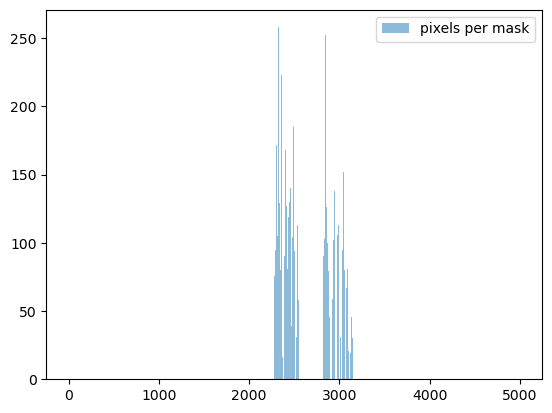

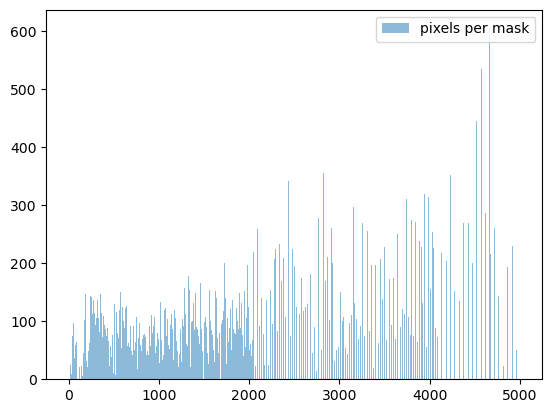

In [10]:
# plot stack histograms of the mask
import matplotlib.pyplot as plt
plt.hist(mask_mini.flatten(), bins=1400, range=(1, 5000), alpha=0.5, label='pixels per mask')
plt.legend(loc='upper right')
plt.show()

#plot the histogram entire original mask stack for comparison (range omits 0 values that are background)
plt.hist(registered_mask.flatten(), bins=5000, range=(1,5000), alpha=0.5, label='pixels per mask')
plt.legend(loc='upper right')
plt.show()

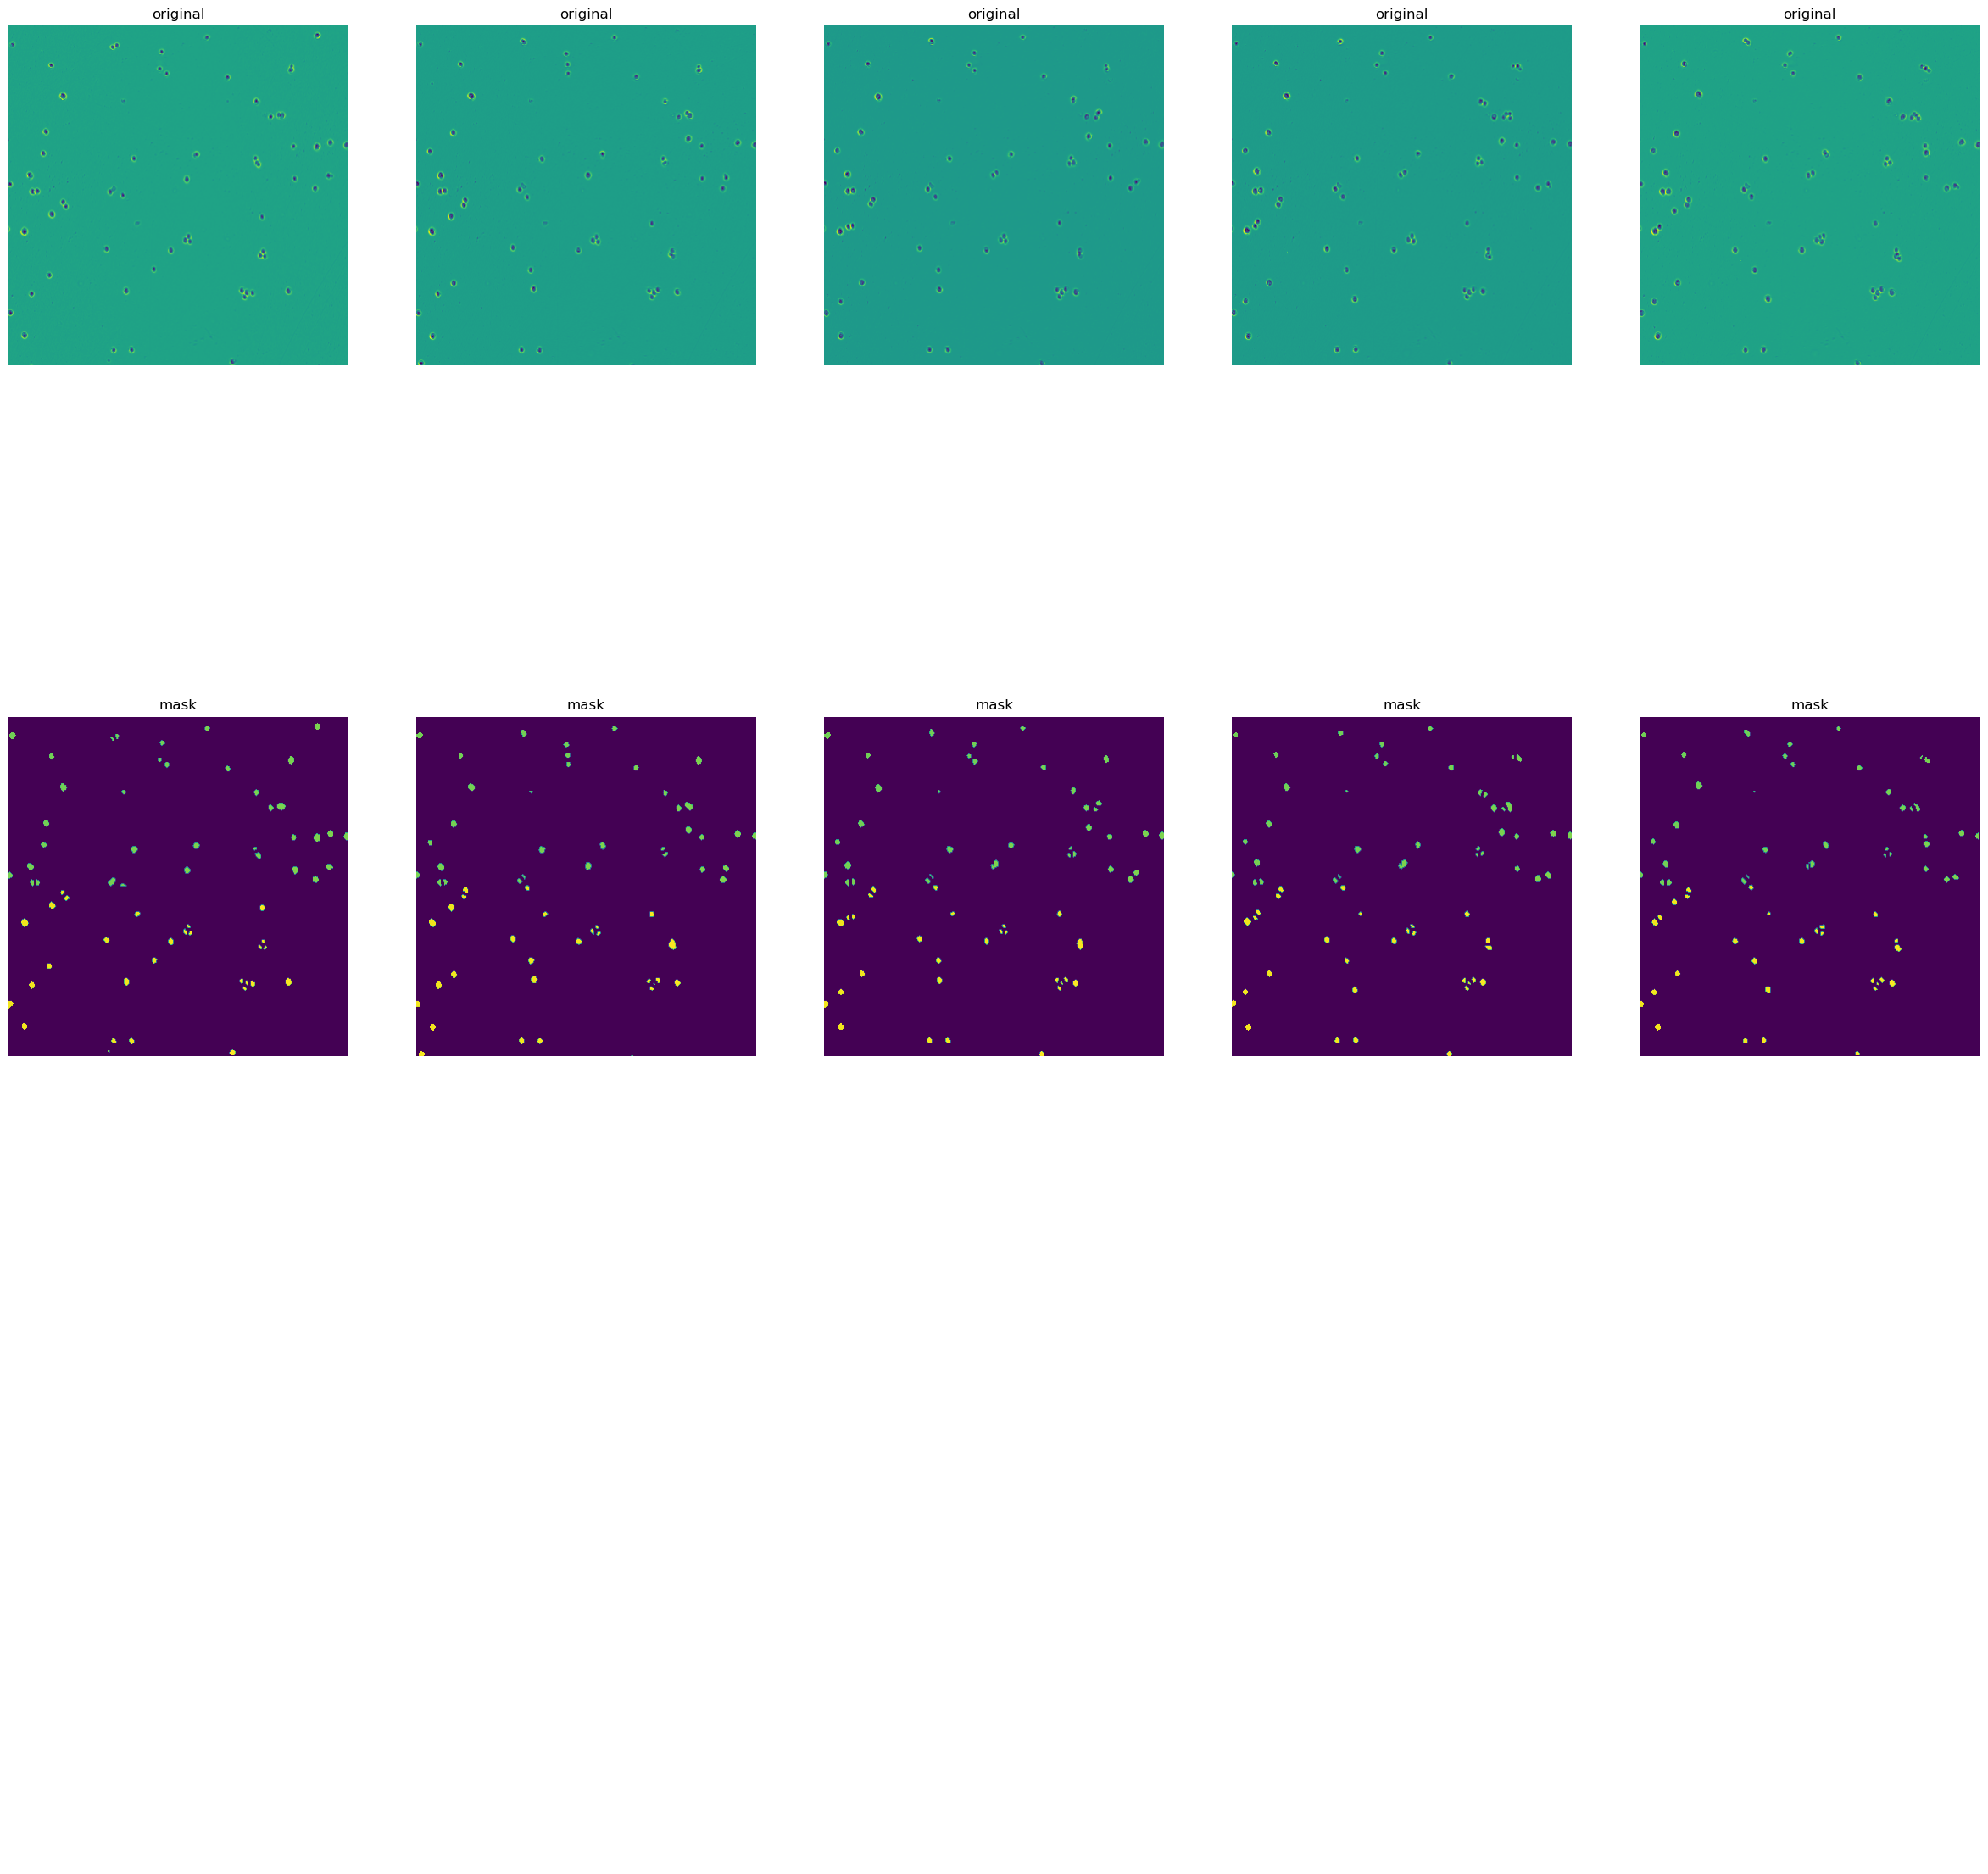

In [11]:
import matplotlib.pyplot as plt
#plot first 3 frames comparing mini_stack and mstack
fig, ax = plt.subplots(3,5, figsize=(30,30))
for i in range(5):
    ax[0,i].imshow(phase_mini[i])
    ax[0,i].axis('off')
    ax[0,i].set_title('original')
    ax[1,i].imshow(mask_mini[i])
    ax[1, i].axis('off')
    ax[1,i].set_title('mask')
    ax[2, i].axis('off')
plt.show()

In [19]:
# save minifields
os.makedirs(os.path.join(outDir, 'mini'), exist_ok=True)
imsave(os.path.join(outDir,'mini/phase_mini.tif'),phase_mini)
imsave(outDir+'mini/mask_mini.tif',mask_mini)
imsave(outDir+'mini/bool_mini.tif', mask_mini.astype('bool'))

/var/folders/5c/jwns6l4s4k5bpg7qvq7k2yzc0000gn/T/ipykernel_39146/449381526.py:4: UserWarning: /Users/zaids/Library/Mobile Documents/com~apple~CloudDocs/Moffitt/mini/mask_mini.tif is a low contrast image
  imsave(outDir+'mini/mask_mini.tif',mask_mini)
/var/folders/5c/jwns6l4s4k5bpg7qvq7k2yzc0000gn/T/ipykernel_39146/449381526.py:5: UserWarning: /Users/zaids/Library/Mobile Documents/com~apple~CloudDocs/Moffitt/mini/bool_mini.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  imsave(outDir+'mini/bool_mini.tif', mask_mini.astype('bool'))


## Use btrack to track the mini field for optimization

In [12]:
objects_mini = btrack.utils.segmentation_to_objects(mask_mini)

[INFO][2023/08/31 02:30:52 PM] Localizing objects from segmentation...
100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 218.76it/s]
[INFO][2023/08/31 02:30:52 PM] Objects are of type: <class 'dict'>
[INFO][2023/08/31 02:30:52 PM] ...Found 403 objects in 6 frames.


In [13]:

with btrack.BayesianTracker() as tracker:

  # configure the tracker using a config file
  tracker.configure(os.path.join(outDir, 'mini','cell_model.json'))

  # append the objects to be tracked
  tracker.append(objects_mini)

  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  #tracker.volume = ((0, 2400), (0, 2400))

  # track them (in interactive mode)
  tracker.track(step_size=100)

  # generate hypotheses and run the global optimizer
  tracker.optimize()

  # store the data in an HDF5 file
  tracker.export(os.path.join(outDir,'mini','tracks_B2_mini.h5'), obj_type='obj_type_1')

  tracks_mini_LBEP = tracker.LBEP


[INFO][2023/08/31 02:30:53 PM] Loaded btrack: /Users/zaids/miniconda3/envs/moffitt/lib/python3.9/site-packages/btrack/libs/libtracker.dylib
[INFO][2023/08/31 02:30:53 PM] Starting BayesianTracker session
[INFO][2023/08/31 02:30:53 PM] Loading configuration file: /Users/zaids/Library/Mobile Documents/com~apple~CloudDocs/Moffitt/mini/cell_model.json
[INFO][2023/08/31 02:30:53 PM] Objects are of type: <class 'list'>
[INFO][2023/08/31 02:30:53 PM] Starting tracking... 
[INFO][2023/08/31 02:30:53 PM] Update using: ['MOTION']
[INFO][2023/08/31 02:30:53 PM] Tracking objects in frames 0 to 6 (of 6)...
[INFO][2023/08/31 02:30:53 PM]  - Timing (Bayesian updates: 2.09ms, Linking: 0.17ms)
[INFO][2023/08/31 02:30:53 PM]  - Probabilities (Link: 1.00000, Lost: 0.34962)
[INFO][2023/08/31 02:30:53 PM] SUCCESS.
[INFO][2023/08/31 02:30:53 PM]  - Found 96 tracks in 6 frames (in 0.0s)
[INFO][2023/08/31 02:30:53 PM]  - Inserted 2 dummy objects to fill tracking gaps
[INFO][2023/08/31 02:30:53 PM] Loading hyp

GLPK Integer Optimizer 5.0
384 rows, 313 columns, 439 non-zeros
313 integer variables, all of which are binary
Preprocessing...
192 rows, 313 columns, 439 non-zeros
313 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 192
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
192 rows, 313 columns, 439 non-zeros
*     0: obj =   1.118474468e+02 inf =   0.000e+00 (31)
*    28: obj =   5.032283137e+01 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+    28: mip =     not found yet >=              -inf        (1; 0)
+    28: >>>>>   5.032283137e+01 >=   5.032283137e+01   0.0% (1; 0)
+    28: mip =   5.032283137e+01 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


In [22]:
tracks_mini_LBEP[0:5] #Get a sample of the btrack mini tracks in LBEP format

array([[1, 0, 0, 1, 1, 0],
       [2, 0, 5, 2, 2, 0],
       [3, 0, 5, 3, 3, 0],
       [4, 0, 5, 4, 4, 0],
       [5, 0, 0, 5, 5, 0]], dtype=int32)

In [25]:
#delete last two columns (Label, Begin Frame (zero-index), End Frame, Root, Generation) - RG not needed
tracks_fram = pd.DataFrame(tracks_mini_LBEP, columns=['L','B','E','P','R','G'])
tracks_fram.set_index('L',inplace=True)

In [26]:
tracks_fram.head()

,B,E,P,R,G
L,,,,,
1,0,0,1,1,0
2,0,5,2,2,0
3,0,5,3,3,0
4,0,5,4,4,0
5,0,0,5,5,0


In [28]:
#Drop the last two columns that are not needed
tracks_out=tracks_fram.iloc[:,:-2]
tracks_out.head()

,B,E,P
L,,,
1,0,0,1
2,0,5,2
3,0,5,3
4,0,5,4
5,0,0,5


In [34]:
#Write to a txt file, in space separated file per CSC guidelines
tracks_out.to_csv(os.path.join(outDir,'mini','01_RES','res_track.txt'),index=True, sep=' ',header=False)

In [43]:
#Now we would run the Cell Challenge Executable

# Now we will try a full-scale tracking with btrack

In [70]:
objects_full = btrack.utils.segmentation_to_objects(
  registered_mask,  properties=('area',  'eccentricity'), assign_class_ID=False)


[INFO][2023/06/08 09:38:00 AM] Localizing objects from segmentation...
[INFO][2023/06/08 09:38:04 AM] Objects are of type: <class 'dict'>
[INFO][2023/06/08 09:38:04 AM] ...Found 13533 objects in 6 frames.


In [71]:
print(objects_full[0].to_dict())

{'ID': 0, 'x': 1181.774193548387, 'y': 125.87096774193549, 'z': 0.0, 't': 0, 'dummy': False, 'states': 7, 'label': 5, 'area': 31, 'eccentricity': 0.31974524290061745}


In [73]:

with btrack.BayesianTracker() as tracker:

  # configure the tracker using a config file
  tracker.configure('C:/Users/zsdqu/OneDrive/Desktop/Moffitt/cell_model_lambda_branching_50.json')

  # append the objects to be tracked
  tracker.append(objects_full)

  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2400), (0, 2400))

  # track them (in interactive mode)
  tracker.track(step_size=100)

  # generate hypotheses and run the global optimizer
  tracker.optimize()

  # store the data in an HDF5 file
  tracker.export(homeDir+'tracks_B2.hdf5', obj_type='obj_type_1')


[INFO][2023/06/08 09:41:34 AM] Loaded btrack: c:\Users\zsdqu\miniconda3\envs\acdc\lib\site-packages\btrack\libs\libtracker.DLL
[INFO][2023/06/08 09:41:34 AM] Starting BayesianTracker session
[INFO][2023/06/08 09:41:34 AM] Loading configuration file: C:/Users/zsdqu/OneDrive/Desktop/Moffitt/cell_model_lambda_branching_50.json
[INFO][2023/06/08 09:41:34 AM] Objects are of type: <class 'list'>
[INFO][2023/06/08 09:41:34 AM] Starting tracking... 
[INFO][2023/06/08 09:41:34 AM] Update using: ['MOTION']
[INFO][2023/06/08 09:41:42 AM] Tracking objects in frames 0 to 6 (of 6)...
[INFO][2023/06/08 09:42:34 AM]  - Timing (Bayesian updates: 16248.00ms, Linking: 25.00ms)
[INFO][2023/06/08 09:42:34 AM]  - Probabilities (Link: 1.00000, Lost: 0.79935)
[INFO][2023/06/08 09:42:34 AM] SUCCESS.
[INFO][2023/06/08 09:42:34 AM]  - Found 3465 tracks in 6 frames (in 0.0s)
[INFO][2023/06/08 09:42:34 AM]  - Inserted 508 dummy objects to fill tracking gaps
[INFO][2023/06/08 09:42:34 AM] Loading hypothesis model: 

# Load Tracks and analyze

In [4]:
#Load the tracks
with btrack.io.HDF5FileHandler(homeDir+'tracks_B2.h5', 'r', obj_type='obj_type_1') as reader:
    # Load the objects
    objects = reader.objects
    tracks = reader.tracks
    lbep_table = reader.lbep

[INFO][2023/06/16 10:02:37 AM] Opening HDF file: /Users/zsdqu/OneDrive/Desktop/Moffitt/tracks_B2.h5...
[INFO][2023/06/16 10:02:37 AM] Loading objects/obj_type_1 (13533, 5) (13533 filtered: None)
[INFO][2023/06/16 10:02:37 AM] Loading tracks/obj_type_1
[INFO][2023/06/16 10:02:37 AM] Loading LBEP/obj_type_1
[INFO][2023/06/16 10:02:37 AM] Loading objects/obj_type_1 (13533, 5) (13533 filtered: None)
[INFO][2023/06/16 10:02:37 AM] Loading LBEP/obj_type_1
[INFO][2023/06/16 10:02:37 AM] Closing HDF file: /Users/zsdqu/OneDrive/Desktop/Moffitt/tracks_B2.h5


In [ ]:
#EXPORT THE TRACKS TO CSV - commented out only need to run once per machine
#btrack.io.export_CSV(homeDir+'tracks_B2.csv', tracks)

In [5]:
# Can reinport into napari for visualization
data_full, properties_full, graph_full = btrack.utils.tracks_to_napari(tracks)

viewer = napari.Viewer()
viewer.add_tracks(data_full, properties=properties_full, graph=graph_full)

<Tracks layer 'data_full' at 0x20aba042ee0>

## LBEP Table showing some features of each track

      Label  Begin t  End t  Parent label  Root label  Generational depth
1457      1        0      5             1           1                   0
1088      2        0      5             2           2                   0
1458      3        0      1             3           3                   0
1459      4        0      5             4           4                   0
1460      5        0      5             5           5                   0
1461      6        0      5             6           6                   0
1462      7        0      5             7           7                   0
1463      8        0      5             8           8                   0
1464      9        0      5             9           9                   0
1456     10        0      5            10          10                   0

Generational Dept Value counts
0    2783
1     380
2      34
3       6
Name: Generational depth, dtype: int64


NameError: name 'plt' is not defined

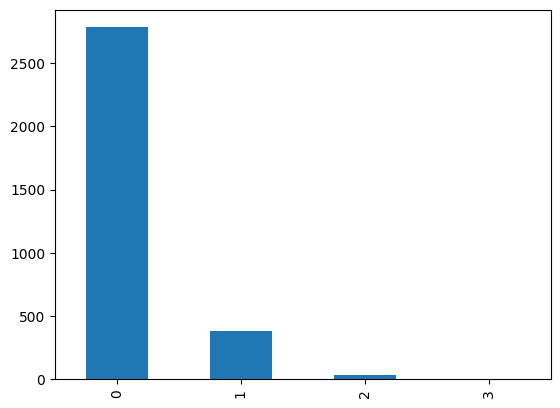

In [6]:
#plot the tracks and lineages with lambda tracking 100
lbep_pd = pd.DataFrame(lbep_table, columns = ['Label','Begin t','End t','Parent label', 'Root label','Generational depth'])
print(lbep_pd.sort_values('Label').head(10))
print("\nGenerational Dept Value counts")
print(lbep_pd['Generational depth'].value_counts())
# use the LBEP table to calculate the generation counts for the cells
lbep_pd['Generational depth'].value_counts().plot(kind='bar')
plt.show()

# Performance metrics

## 1) How many cells detected at first time point are detected at the last time point

In [7]:
#how many cells at t=0 are present at t=5?
print(lbep_pd.loc[(lbep_pd['Begin t']==0) & (lbep_pd['End t']==5)])
print(lbep_pd.loc[(lbep_pd['Begin t']==0) & (lbep_pd['End t']==5)].shape[0])
#

      Label  Begin t  End t  Parent label  Root label  Generational depth
1      1456        0      5          1456        1456                   0
2      1457        0      5          1457        1457                   0
3      1458        0      5          1458        1458                   0
4      1459        0      5          1459        1459                   0
5      1460        0      5          1460        1460                   0
...     ...      ...    ...           ...         ...                 ...
2178    724        0      5           724         724                   0
2181    727        0      5           727         727                   0
2184    730        0      5           730         730                   0
2186    732        0      5           732         732                   0
2189    735        0      5           735         735                   0

[1659 rows x 6 columns]
1659


## 2) for cells that at some point end up being a parent: circular cross correlation between real time and cell size (they should become larger up until they divide)

In [ ]:
#TODO

## 3) for mitotic events, create a histogram of size parent/1/2(size daughters)

In [20]:
# first inport the csv from btrack
btracks_file = homeDir+'tracks_B2.csv'

# read in the csv
btracks = pd.read_csv(btracks_file)

print(btracks.head(10))

     ID  t            x           y    z  parent  root  state  generation  \
0  1464  0  1369.787842  147.393936  0.0    1464  1464      5           0   
1  1456  0  1176.838745  207.225800  0.0    1456  1456      5           0   
2  1456  1  1177.153809  206.923080  0.0    1456  1456      5           0   
3  1456  2  1176.942871  208.285721  0.0    1456  1456      5           0   
4  1456  3  1173.963013  205.222229  0.0    1456  1456      5           0   
5  1456  4  1174.485718  205.399994  0.0    1456  1456      5           0   
6  1456  5  1174.516113  206.483871  0.0    1456  1456      5           0   
7  1457  0  1348.416626  147.166672  0.0    1457  1457      5           0   
8  1457  1  1348.416626  147.166672  0.0    1457  1457      5           0   
9  1457  2  1348.416626  147.166672  0.0    1457  1457      5           0   

   dummy  area  eccentricity  
0      0  33.0      0.810396  
1      0  31.0      0.456223  
2      0  39.0      0.543040  
3      0  35.0      0.743515

In [34]:
# Create a lookup table for the size of the cell at the last time point it is seen as well as another table for every cell that is not its own parent


first_size = defaultdict(list)  # list will be [t-at first time seen, area]
last_size = defaultdict(list)  # list will be [t-at last time seen, area]
progenies = defaultdict(set)  # parentID:[childID1, childID2]

for index, row in btracks.iterrows():
    if row['ID'] not in first_size or row['t'] < first_size[row['ID']][0]:
        first_size[row['ID']] = [row['t'], row['area']]
    if row['ID'] not in last_size or row['t'] > last_size[row['ID']][0]:
        last_size[row['ID']] = [row['t'], row['area']]
    #for every divided cell, the parent of it will serve as key to lookup it's 2 children
    if row['ID'] != row['parent']:
        progenies[row['parent']].add(row['ID'])

# for all elements of the progenies list, find the ratio of (last_size of the progeny key)/average(first_size of progeny areas values)
size_ratios = []

for parent in progenies.keys():
    size_ratios.append(int(last_size[parent][1]) / int(np.average(list(first_size[child][1] for child in progenies[parent]))))

print(size_ratios[0:10])



[1.2222222222222223, 2.875, 1.1111111111111112, 1.0526315789473684, 1.5, 1.8571428571428572, 1.1, 0.9, 0.9615384615384616, 0.5]


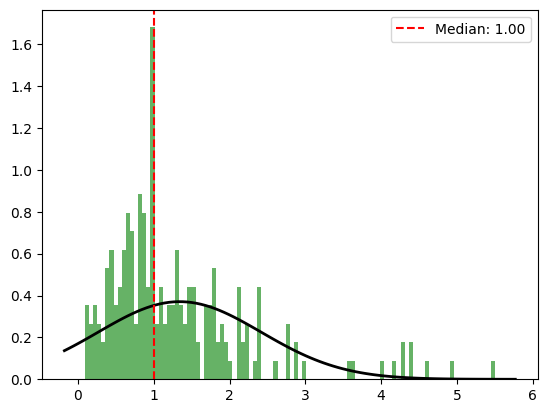

In [35]:
# plot the size ratios as a histogram with a fitted curve
from scipy.stats import norm

mu, std = norm.fit(size_ratios)
plt.hist([ratio for ratio in size_ratios if ratio<=6], bins=100, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Calculate and plot the median
median = np.median(size_ratios)
plt.axvline(median, color='r', linestyle='--', label='Median: {:.2f}'.format(median))
plt.legend()
plt.show()

In [36]:
# DO the same for ilastik tracks
ilastik_file = homeDir+'ilastik_tracks.csv'
itracks = pd.read_csv(ilastik_file)

first_size = defaultdict(list)  # list will be [t-at first time seen, area]
last_size = defaultdict(list)  # list will be [t-at last time seen, area]
progenies = defaultdict(set)  # parentID:[childID1, childID2]

for index, row in itracks.iterrows():
    if row['trackId'] not in first_size or row['frame'] < first_size[row['trackId']][0]:
        first_size[row['trackId']] = [row['frame'], row['Object_Area_0']]
    if row['trackId'] not in last_size or row['frame'] > last_size[row['trackId']][0]:
        last_size[row['trackId']] = [row['frame'], row['Object_Area_0']]
    #there is a different convention for ilastic where cells that don't have a parent have parent 0 rather than parent "cellID"
    if row['parentTrackId']!=0: 
        progenies[row['parentTrackId']].add(row['trackId'])

# for all elements of the progenies list, find the ratio of (last_size of the progeny key)/average(first_size of progeny areas values)
size_ratios_ilastik= []

for parent in progenies.keys():
    size_ratios_ilastik.append(int(last_size[parent][1]) / int(np.average(list(first_size[child][1] for child in progenies[parent]))))

print(size_ratios[0:10])

[1.2222222222222223, 2.875, 1.1111111111111112, 1.0526315789473684, 1.5, 1.8571428571428572, 1.1, 0.9, 0.9615384615384616, 0.5]


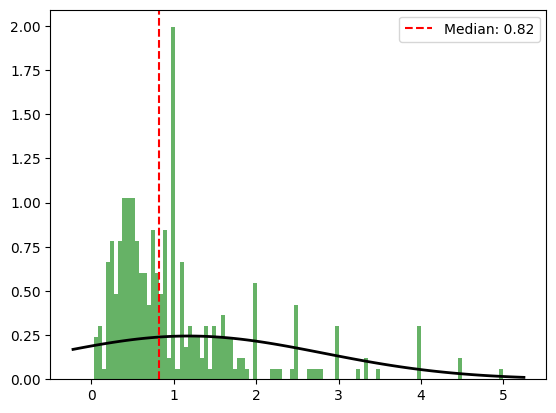

In [37]:
# plot the size ratios as a histogram with a fitted curve
from scipy.stats import norm

mu, std = norm.fit(size_ratios_ilastik)
plt.hist([ratio for ratio in size_ratios_ilastik if ratio<=6], bins=100, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Calculate and plot the median
median = np.median(size_ratios_ilastik)
plt.axvline(median, color='r', linestyle='--', label='Median: {:.2f}'.format(median))
plt.legend()


plt.show()

In [38]:
#same except for ground truth ilastik tracks
ilastik_file = homeDir+'GTruth.csv'
itracks = pd.read_csv(ilastik_file)

first_size = defaultdict(list)  # list will be [t-at first time seen, area]
last_size = defaultdict(list)  # list will be [t-at last time seen, area]
progenies = defaultdict(set)  # parentID:[childID1, childID2]

for index, row in itracks.iterrows():
    if row['trackId'] not in first_size or row['frame'] < first_size[row['trackId']][0]:
        first_size[row['trackId']] = [row['frame'], row['Object_Area_0']]
    if row['trackId'] not in last_size or row['frame'] > last_size[row['trackId']][0]:
        last_size[row['trackId']] = [row['frame'], row['Object_Area_0']]
    #there is a different convention for ilastic where cells that don't have a parent have parent 0 rather than parent "cellID"
    if row['parentTrackId']!=0: 
        progenies[row['parentTrackId']].add(row['trackId'])

# for all elements of the progenies list, find the ratio of (last_size of the progeny key)/average(first_size of progeny areas values)
size_ratios_ilastik= []

for parent in progenies.keys():
    size_ratios_ilastik.append(int(last_size[parent][1]) / int(np.average(list(first_size[child][1] for child in progenies[parent]))))

print(size_ratios[0:10])

[1.2222222222222223, 2.875, 1.1111111111111112, 1.0526315789473684, 1.5, 1.8571428571428572, 1.1, 0.9, 0.9615384615384616, 0.5]


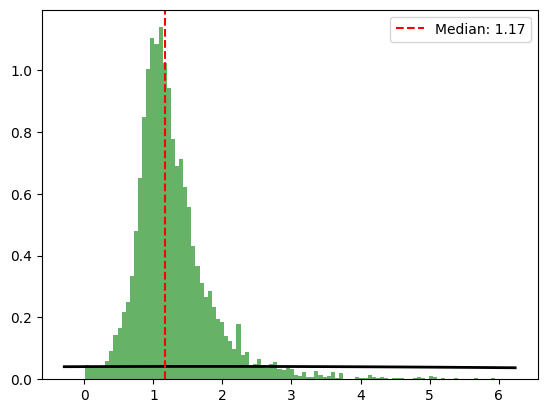

In [39]:
# plot the size ratios as a histogram with a fitted curve
from scipy.stats import norm

mu, std = norm.fit(size_ratios_ilastik)
plt.hist([ratio for ratio in size_ratios_ilastik if ratio<=6], bins=100, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Calculate and plot the median
median = np.median(size_ratios_ilastik)
plt.axvline(median, color='r', linestyle='--', label='Median: {:.2f}'.format(median))
plt.legend()

plt.show()

## 4) Track cell size over time

C:\Users\zsdqu\AppData\Local\Temp\ipykernel_2548\1831154950.py:23: RuntimeWarning: Mean of empty slice
  mean_area = np.nanmean(all_areas, axis=0)
c:\Users\zsdqu\miniconda3\envs\acdc\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


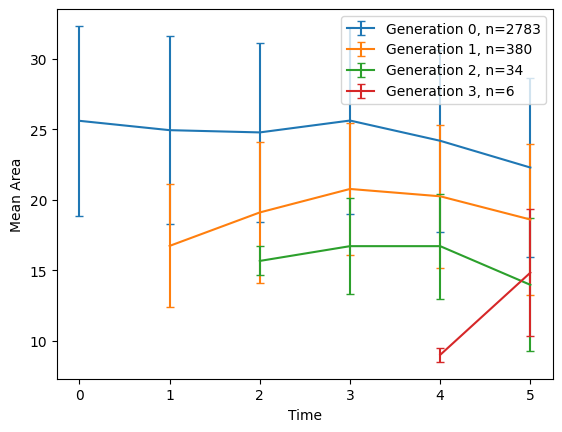

In [19]:
from collections import defaultdict

# Find the maximum length of 't' across all tracks
max_len = max(len(track['t']) for track in tracks)

# Create new structures for padded 'area' arrays
padded_areas_by_track = {}
for track in tracks:
    pad_length = max_len - len(track['t'])
    padded_area = np.pad(track['area'], (pad_length, 0), 'constant', constant_values=np.nan)
    padded_areas_by_track[track['ID']] = padded_area

# Now you can segregate the track IDs by generation and calculate the mean and standard deviation
generations = set(track['generation'] for track in tracks)
track_ids_by_gen = {gen: [track['ID'] for track in tracks if track['generation'] == gen] for gen in generations}

# For each generation...
for gen, gen_track_ids in track_ids_by_gen.items():
    # Compute mean and standard deviation of area at each time point
    all_areas = [padded_areas_by_track[id] for id in gen_track_ids]
    mean_area = np.nanmean(all_areas, axis=0)
    std_area = np.nanstd(all_areas, axis=0) * 0.5  # Get half the standard deviation

    # Plot mean area with error bars for this generation
    plt.errorbar(range(len(mean_area)), mean_area, yerr=std_area, capsize=3, label=f'Generation {gen}, n={len(gen_track_ids)}, btrack-base')

# Add labels, legend, and show plot
plt.xlabel('Time')
plt.ylabel('Mean Area')
plt.legend(loc='upper right')
plt.show()


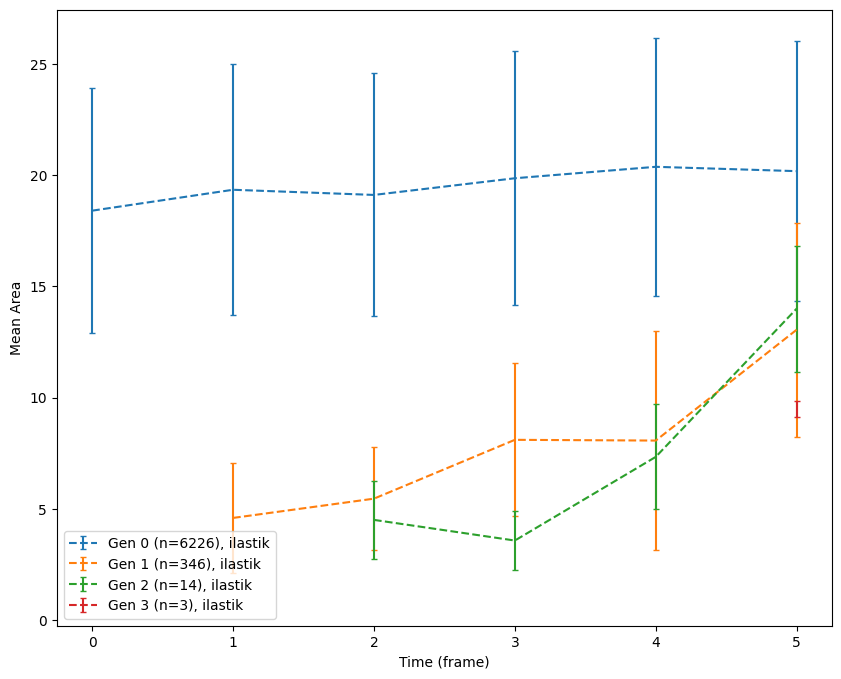

In [40]:
# Load the data (replace 'data.csv' with your actual file path)
df = pd.read_csv(homeDir+'ilastik_tracks.csv')

# Convert frame, trackId, parentTrackId to integers
df['frame'] = df['frame'].astype(int)
df['trackId'] = df['trackId'].astype(int)
df['parentTrackId'] = df['parentTrackId'].astype(int)

# Function to calculate generations
def calculate_generation(track_id, parent_id_dict, gen_cache):
    if track_id not in gen_cache:
        parent_id = parent_id_dict[track_id]
        if parent_id is None or parent_id == 0:  # Treat 0 as root
            gen_cache[track_id] = 0
        else:
            gen_cache[track_id] = calculate_generation(parent_id, parent_id_dict, gen_cache) + 1
    return gen_cache[track_id]

# Create a parentTrackId dictionary, set parentTrackId of 0 to None
parent_id_dict = df.set_index('trackId')['parentTrackId'].replace({0: None}).to_dict()

# Calculate generations
gen_cache = {}
df['generation'] = df['trackId'].apply(lambda x: calculate_generation(x, parent_id_dict, gen_cache))

# Group by trackId to create tracks
grouped = df.groupby('trackId')

tracks = []
for name, group in grouped:
    tracks.append({
        'id': name,
        'generation': group['generation'].iloc[0],
        'frame': group['frame'].tolist(),
        'area': group['Object_Area_0'].tolist()
    })

# Count unique tracks for each generation
unique_tracks = df.groupby('generation')['trackId'].nunique()

# Transform the tracks data to dataframe
tracks_df = pd.concat([pd.DataFrame({'frame': track['frame'], 'area': track['area'], 'generation': track['generation']}) for track in tracks])

# Group the data by frame and generation, calculate mean and standard deviation of areas
mean_df = tracks_df.groupby(['frame', 'generation'])['area'].mean().unstack()
std_df = tracks_df.groupby(['frame', 'generation'])['area'].std().unstack()

# Plot mean area over time for each generation with error bars
plt.figure(figsize=(10, 8))

for gen in mean_df.columns:
    mean_area = mean_df[gen]
    std_area = std_df[gen] * 0.5  # half standard deviation for error bars
    plt.errorbar(mean_area.index, mean_area, yerr=std_area, capsize=2,
                 linestyle='dashed', label=f'Gen {gen} (n={unique_tracks[gen]}), ilastik')

plt.xlabel('Time (frame)')
plt.ylabel('Mean Area')
plt.legend()
plt.show()

# troubleshooting
## fragmented tracks below (solved 5/18/23 due to interpolation artifact in masks leading to periphery being counted as multiple objects)

In [112]:
objects_mark = btrack.utils.segmentation_to_objects(mark_mini, properties=('area', ), assign_class_ID=False)
objects_mark[0]

[INFO][2023/05/12 10:53:54 AM] Localizing objects from segmentation...
[INFO][2023/05/12 10:53:54 AM] Objects are of type: <class 'dict'>
[INFO][2023/05/12 10:53:54 AM] ...Found 427 objects in 5 frames.


,ID,x,y,z,t,dummy,states,label,area
0,0,675.45098,5.843137,0.0,0,False,7,5,51


In [115]:
import pandas as pd
pd.DataFrame.from_records([object.to_dict() for object in objects]).groupby('t').count()

,ID,x,y,z,dummy,states,label,area
t,,,,,,,,
0,207,207,207,207,207,207,207,207
1,265,265,265,265,265,265,265,265
2,243,243,243,243,243,243,243,243
3,251,251,251,251,251,251,251,251
4,244,244,244,244,244,244,244,244


In [68]:
#Test if subtracting 800 from all values in mask_mini except zero-valued pixels will work
offset = 894

mask_mini2 = np.where(mask_mini > 0, mask_mini - offset, mask_mini)

print(mask_mini2.shape, " = Shape of mask_mini2")
print(np.unique(mask_mini2), " = Unique values in mask_mini2")
print(np.unique(mask_mini2).shape, " = Number of unique values in mask_mini2")


(5, 200, 200)  = Shape of mask_mini2
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  31  32  33  34  35  36
  37  38  39 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289
 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307
 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325
 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343
 344 345 346 347 348 349 350 351 353 354 355 359 360 361 362 363 364 365
 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383
 384 386 387 388 389 390 391 392 393 394 395 396 397 398 400 401 402]  = Unique values in mask_mini2
(161,)  = Number of unique values in mask_mini2


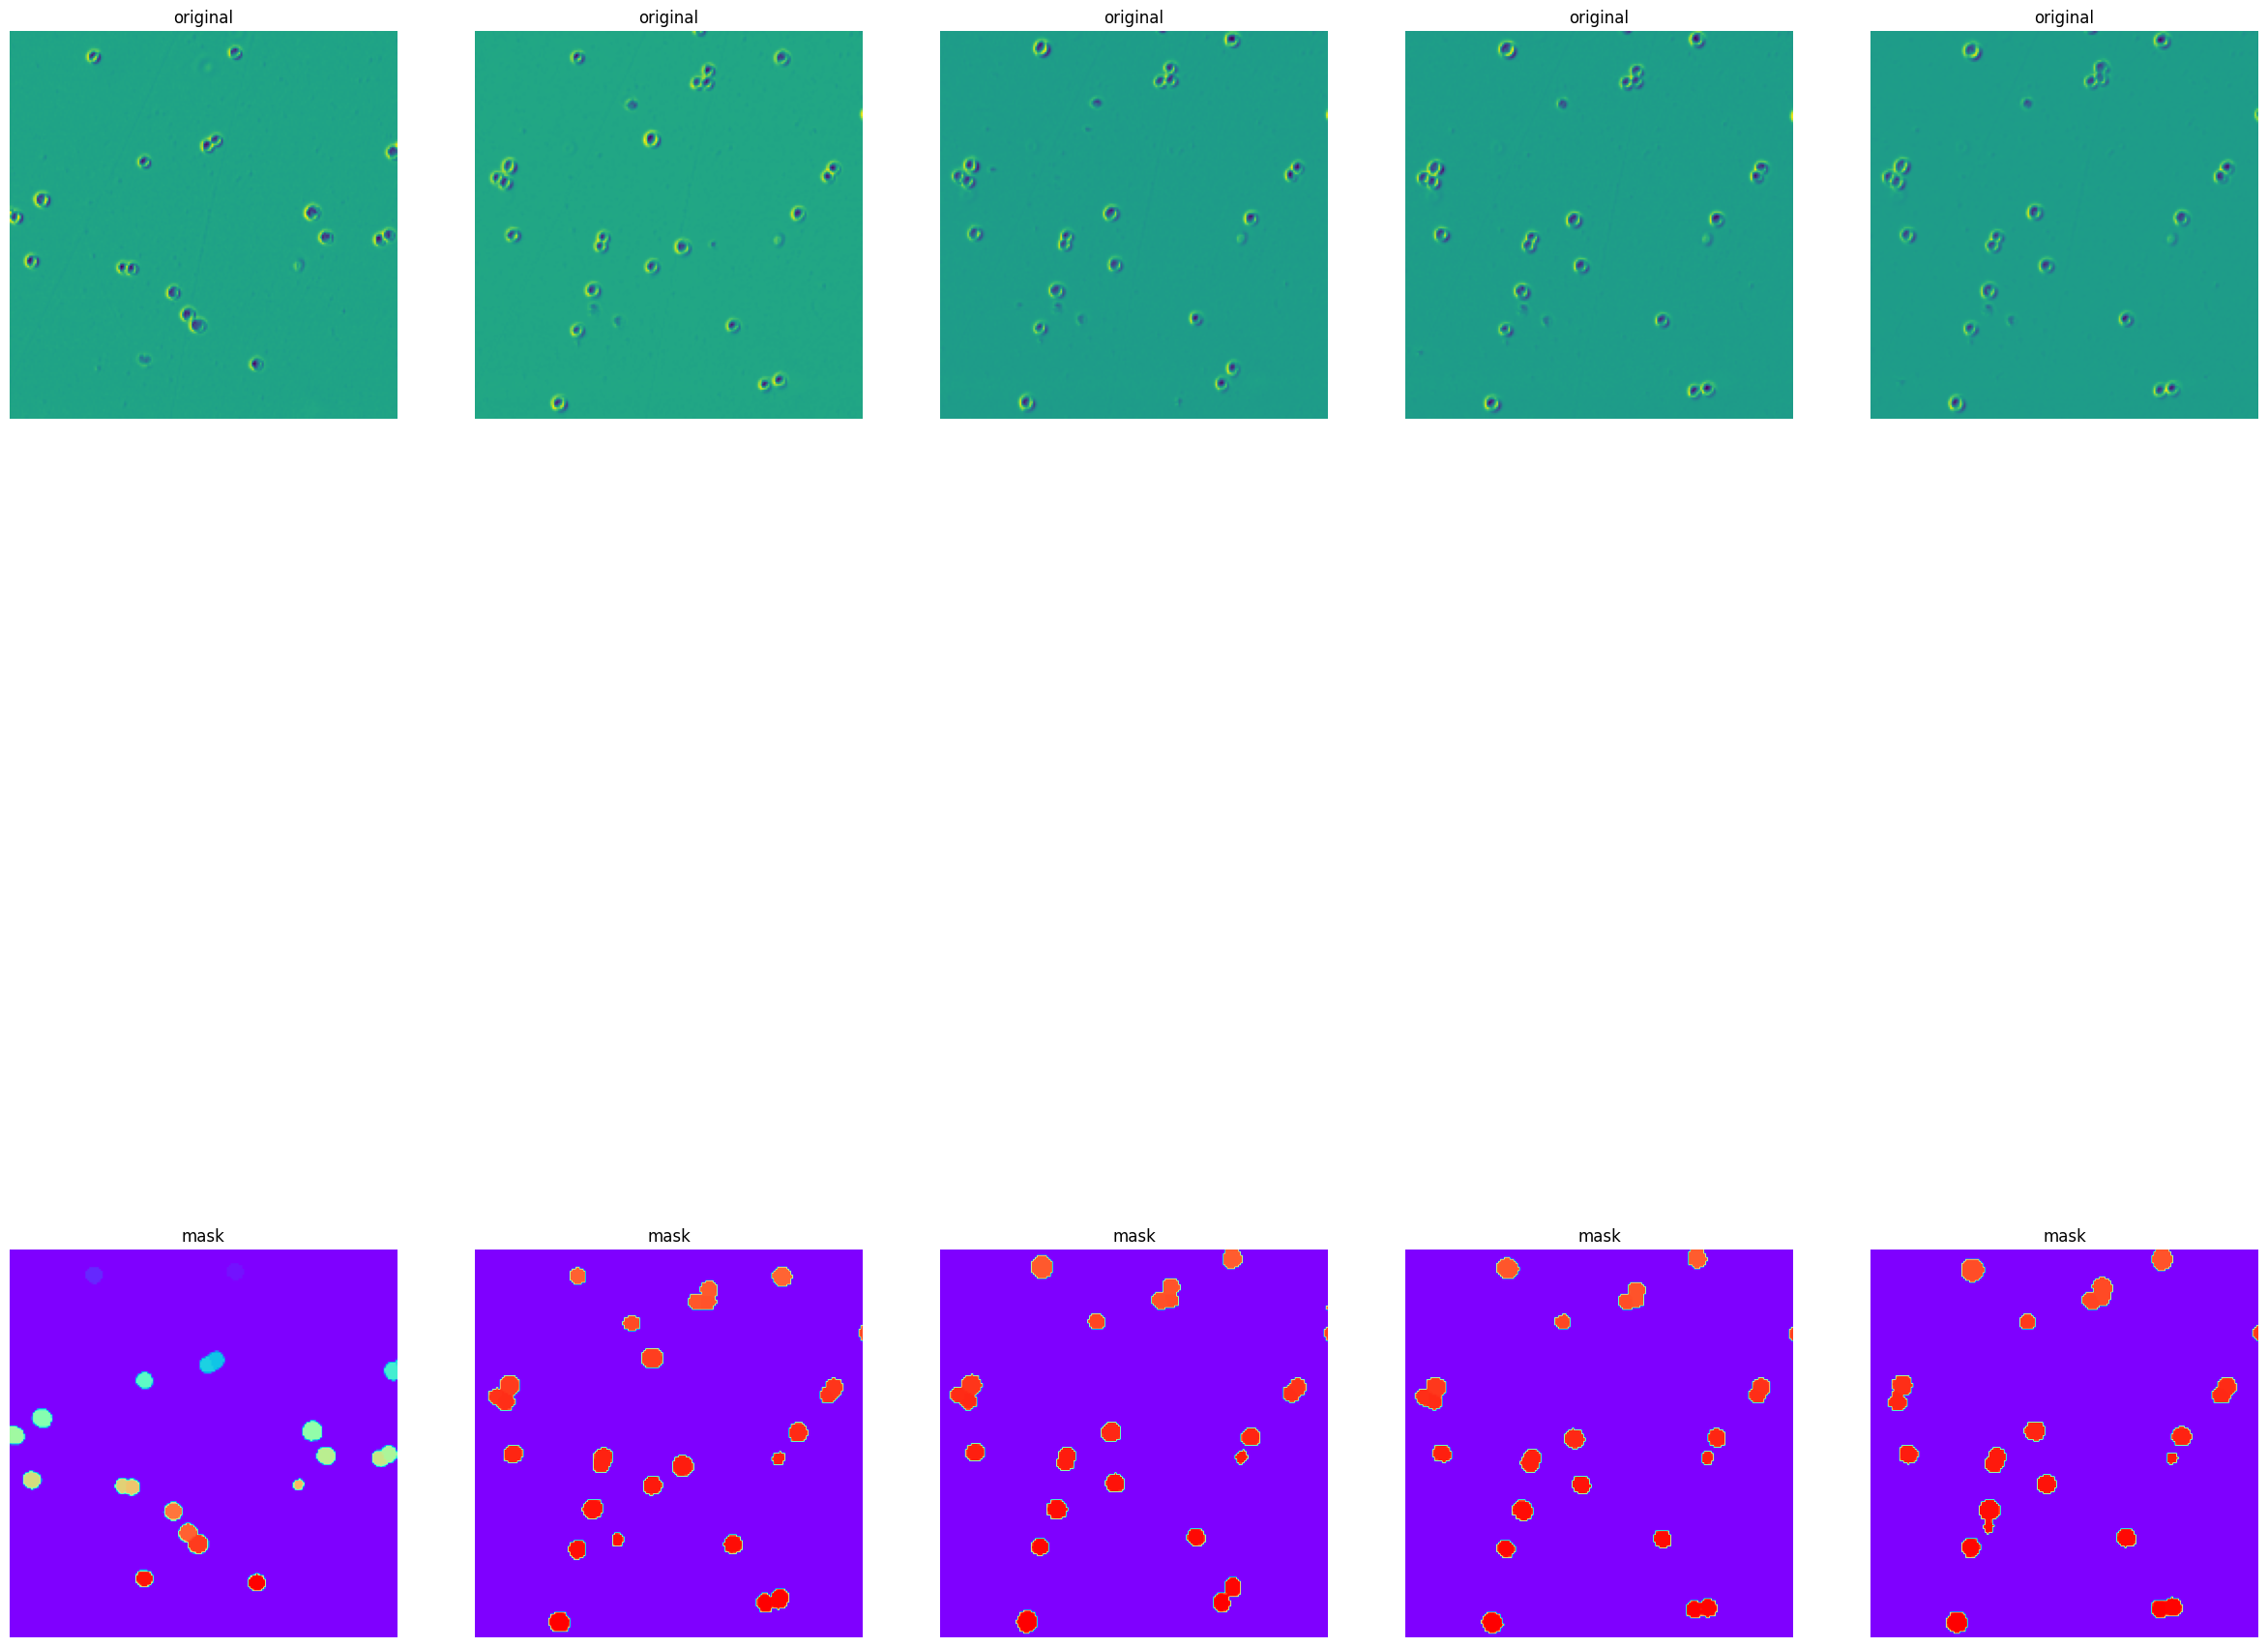

In [72]:
import matplotlib.pyplot as plt
#plot first 3 frames comparing mini_stack and mstack
fig, ax = plt.subplots(2,5, figsize=(30,30))
for i in range(5):
    ax[0,i].imshow(phase_mini[i])
    ax[0,i].axis('off')
    ax[0,i].set_title('original')
    ax[1,i].imshow(mask_mini2[i], cmap='rainbow')
    ax[1, i].axis('off')
    ax[1,i].set_title('mask')

In [73]:
#try tracking with the new mask
objects2 = btrack.utils.segmentation_to_objects(
    mask_mini2,  properties=('area', ), assign_class_ID=True)

[INFO][2023/05/12 09:54:32 AM] Localizing objects from segmentation...
[INFO][2023/05/12 09:54:32 AM] Objects are of type: <class 'dict'>
[INFO][2023/05/12 09:54:32 AM] ...Found 1209 objects in 5 frames.
